# REFERENCES:

* http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity
* https://newspaper.readthedocs.io/en/latest/
* https://www.geeksforgeeks.org/newspaper-article-scraping-curation-python/
* https://machinelearningmastery.com/clean-text-machine-learning-python/
* https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
* https://scikit-learn.org/stable/index.html

# Installing the newspaper3k library

In [ ]:
# !pip install newspaper3k

# Importing libraries

In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.decomposition import PCA
import seaborn as sns
from newspaper import Article
import requests
from bs4 import BeautifulSoup

# Importing dataset: Online news popularity from UCI library

In [252]:
data = pd.read_csv("../input/uci-online-news-popularity-data-set/OnlineNewsPopularity.csv")

# Cleansing the column names

In [253]:
def cleancols(cols):
    x = [y.lower().strip() for y in cols]
    return x

In [254]:
data.columns = cleancols(data.columns)
y_labels = data['shares'] #the feature to be predicted
df = data.drop(columns = ['url','timedelta','shares'],axis = 1) #url and timedelta are of no use to us

# Scraping news articles from the web

### We use the BBC News website for testing our model that would be trained on UCI dataset. We observe the feature that we find useful, here the specific 'class' attribute

In [255]:
url = "https://www.bbc.com/news/world"
page = requests.get(url)
soup = BeautifulSoup(page.content,'html.parser')
imgnews = soup.findAll('a',attrs = {'class':'gs-c-promo-heading gs-o-faux-block-link__overlay-link gel-pica-bold nw-o-link-split__anchor'})

### Creating the list of news articles

In [256]:
newsarts = []
for arts in imgnews:
    newsarts.append("https://www.bbc.com"+arts['href'])

### Before we move on to extraction of information, we need to figure out the features of the UCI Dataset that we would be creating, out the extracted news, for prediction purpose

In [ ]:
pca = PCA(n_components = 12)
df_scaled = pd.DataFrame(preprocessing.scale(df),columns = df.columns)
df_red = pca.fit_transform(df_scaled) #applying PCA on the standardized data
explainedfeats = pd.DataFrame(pca.components_,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10','PC-11','PC-12'],columns = df.columns)

### Using XGBoost to find the absolute importance of each feature. This is done so that we can minimize our effort of making features while converting extracted news article in the format of the Online News Popularity Dataset

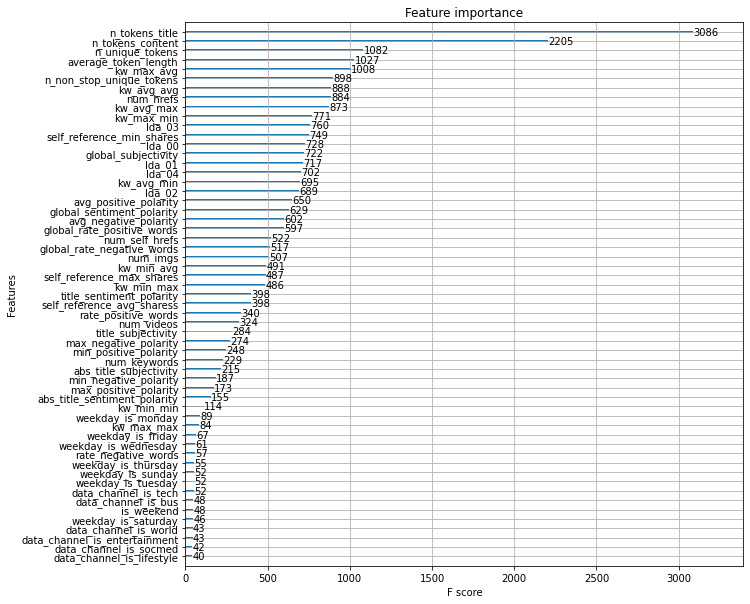

In [257]:
xgb = XGBRegressor(max_depth = 10,random_state = 42)
xgb.fit(df,y_labels)
fig, ax = plt.subplots(1,1,figsize=(10,10))
impplot = plot_importance(xgb,ax = ax)
plt.show()

In [258]:
impfeats = [impplot.get_yticklabels()[::-1][i].get_text() for i in range(0,20)]
print(impfeats)

['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'average_token_length', 'kw_max_avg', 'n_non_stop_unique_tokens', 'kw_avg_avg', 'num_hrefs', 'kw_avg_max', 'kw_max_min', 'lda_03', 'self_reference_min_shares', 'lda_00', 'global_subjectivity', 'lda_01', 'lda_04', 'kw_avg_min', 'lda_02', 'avg_positive_polarity', 'global_sentiment_polarity']


### Finding the top 20 important features: (DNC : did not consider as unable to figure out calculation steps for that feature )
*   n_tokens_title : Number of words in the title
*   n_tokens_content: Number of words in the content 
*   n_unique_tokens : Rate of unique words in the content ( #unique words / #words )
*   average_token_length : Average length of the words in the content 
*   n_non_stop_unique_tokens : Rate of unique non-stop words in the content
*   num_hrefs : Number of links
*   global_subjectivity : subjectivity of article content
*   avg_positive_polarity : Average polarity of positive words
*   global_sentiment_polarity : Text sentiment polarity
*   kw_max_avg : DNC
*   kw_avg_avg : DNC
*   kw_avg_max : DNC
*   kw_max_min : DNC
*   lda_03 : DNC
*   self_reference_min_shares : DNC
*   lda_00 : DNC
*   lda_01 : DNC
*   lda_04 : DNC
*   kw_avg_min : DNC
*   lda_02 : DNC

### Out of these, let us try to construct the features which are defined clearly in the details of the UCI dataset website.
### 9 features could be figured out.

# Importing libraries for analyzing the article text

In [259]:
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))
from textblob import TextBlob #for subjectivity and polarity purpose

# Defining functions that would return feature values

In [260]:
def tokenizetext(text):
    return word_tokenize(text)
def words(text):
    l = [word for word in word_tokenize(text) if word.isalpha()]
    return l
def unique_words(text):
    return list(set(words(text)))
def rate_uni_words(text):
    uni_words = len(unique_words(text))/len(words(text))
    return uni_words
def avglengthtoken(text):
    w = words(text)
    sum = 0
    for item in w:
        sum+=len(item)
    avglen = sum/len(w)
    return avglen
def n_non_stop_unique_tokens(text):
    uw = unique_words(text)
    n_uw = [item for item in uw if item not in stopwords]
    w = words(text)
    n_w = [item for item in w if item not in stopwords]
    rate_nsut = len(n_uw)/len(n_w)
    return rate_nsut
def numlinks(article):
    return len(BeautifulSoup(sampletext.html).findAll('link'))
def get_subjectivity(a_text):
    return a_text.sentiment.subjectivity
def get_polarity(a_text):
    return a_text.sentiment.polarity
def word_polarity(words):
    pos_words = []
    ppos_words = [] # polarity of pos words
    neg_words = []
    pneg_words = [] # polarity of negative words
    neu_words = []
    pneu_words = [] # polarity of neutral words
    for w in words:
        an_word = TextBlob(w)
        val = an_word.sentiment.polarity
        if val > 0:
            pos_words.append(w)
            ppos_words.append(val)
        if val < 0:
            neg_words.append(w)
            pneg_words.append(val)
        if val == 0 :
            neu_words.append(w)
            pneu_words.append(val)
    return pos_words,ppos_words,neg_words,pneg_words,neu_words,pneu_words
def avg_pol_pw(text):    
    totalwords = words(text)
    res = word_polarity(totalwords)
    return np.sum(res[1])/len(res[0])
def avg_pol_nw(text):    
    totalwords = words(text)
    res = word_polarity(totalwords)
    return np.sum(res[3])/len(res[2])

# Creating dataset with news articles 

In [261]:
finrows = []
for article in newsarts[0:25]:
    sampletext = Article(article, language = 'en')
    sampletext.download()
    sampletext.parse()
    sampletext.nlp() 
    
    row = {}
    row['n_tokens_title'] = len(words(sampletext.title))
    row['n_tokens_content'] = len(words(sampletext.text))
    row['n_unique_tokens'] = len(unique_words(sampletext.text))
    row['average_token_length'] = avglengthtoken(sampletext.text)
    row['n_non_stop_unique_tokens'] = n_non_stop_unique_tokens(sampletext.text)
    row['num_hrefs'] = numlinks(sampletext)
    
    analysed_text = TextBlob(sampletext.text)
    row['global_subjectivity'] = get_subjectivity(analysed_text)
    row['avg_positive_polarity'] = avg_pol_pw(sampletext.text)
    row['global_sentiment_polarity'] = get_polarity(analysed_text)
    finrows.append(row)
#converting the list to a dataframe
masterdf = pd.DataFrame(finrows, columns = ['n_tokens_title','n_tokens_content','n_unique_tokens','average_token_length','n_non_stop_unique_tokens','num_hrefs','global_subjectivity',
                                   'avg_positive_polarity','global_sentiment_polarity'])

## This dataset will now be used in the end for prediction purpose

# Converting UCI dataset

In [262]:
df_reduced = df[masterdf.columns]

# Splitting the UCI dataset into training and testing

In [263]:
xtrain, xtest, ytrain, ytest = train_test_split(df_reduced, y_labels, test_size = 0.2, shuffle = True, random_state = 42)

# REGRESSOR TESTING

# 1. XGBoost 

In [264]:
xgb2 = XGBRegressor(random_state = 42)
paramsxgb = {'max_depth':[5,20,50,100]}
gsc = GridSearchCV(estimator = xgb2,param_grid = paramsxgb, cv = 3, scoring = 'neg_root_mean_squared_error')
gscres = gsc.fit(xtrain,ytrain)
gscres.best_params_

{'max_depth': 5}

In [265]:
xgb2.max_depth = gscres.best_params_['max_depth']
boost = ['gbtree','gblinear']
rmsescores = {}
for b in boost:
    xgb2.booster = b
    xgb2.fit(xtrain,ytrain)
    predicted = xgb2.predict(xtest)
    rmsescores['xgb-'+b] = RMSE(ytest,predicted,squared = False)
    print("RMSE error with {} booster is {} :".format(b,RMSE(ytest,predicted,squared = False)))

RMSE error with gbtree booster is 11431.556668640484 :
RMSE error with gblinear booster is 10973.181940995893 :


## Best depth is found to be 5 and on testing setting the booster to 'gblinear' gives lower RMSE score ~ 10900 compared to 'gbtree' with a RMSE score ~ 11430. Hence, I have set the booster to 'gblinear'

In [266]:
xgb2.booster = 'gblinear'

# 2. RandomForestRegressor

In [268]:
rf = RandomForestRegressor(random_state = 42)
paramsrf = {'max_depth':[5,20,50,100]}
gsc = GridSearchCV(estimator = rf,param_grid = paramsrf, cv = 3, scoring = 'neg_root_mean_squared_error')
gscres = gsc.fit(xtrain,ytrain)
gscres.best_params_

{'max_depth': 5}

In [269]:
rf.max_depth = gscres.best_params_['max_depth']
rf.fit(xtrain,ytrain)
predictedrf = rf.predict(xtest)
rmsescores['rf'] = RMSE(ytest,predictedrf,squared = False)
print("RMSE error with Random Forest Regressor is {} :".format(RMSE(ytest,predicted,squared = False)))

RMSE error with Random Forest Regressor is 10973.181940995893 :


## Best depth is found to be 5 with RMSE score ~ 10900, similar to XGBoost with gblinear regressor

# 3. Linear Regression (RidgeCV): linear regression with l2 regularization and in-built CV

In [296]:
lr = RidgeCV(alphas = [0.001,0.1,1,5,10,100],scoring = 'neg_root_mean_squared_error', cv = None, store_cv_values = True)
lr.fit(xtrain,ytrain)

RidgeCV(alphas=array([1.e-03, 1.e-01, 1.e+00, 5.e+00, 1.e+01, 1.e+02]), cv=None,
        fit_intercept=True, gcv_mode=None, normalize=False,
        scoring='neg_root_mean_squared_error', store_cv_values=True)

In [300]:
predictedlr = lr.predict(xtest)
rmsescores['ridgecv'] = RMSE(ytest,predictedlr,squared = False)
print("RMSE error with Linear Regression via RidgeCV is {} :".format(RMSE(ytest,predictedlr,squared = False)))

RMSE error with Linear Regression via RidgeCV is 10952.058107374436 :


## RMSE score for RidgeCV regression is found to be lowest compared to XGBoost and Random Forest Regressor

# 4. CatBoost

In [303]:
cb = CatBoostRegressor(verbose = 0,random_state = 42,eval_metric = 'RMSE')
paramscb = {'iterations':[1,10,50,100],'learning_rate':[0.03,0.1,0.5,1],'depth':[3,5,8,10]}
gsc = GridSearchCV(estimator = cb,param_grid = paramscb, cv = 3, scoring = 'neg_root_mean_squared_error')
gscres = gsc.fit(xtrain,ytrain)
gscres.best_params_

{'depth': 10, 'iterations': 50, 'learning_rate': 0.03}

In [304]:
cb.iterations = gscres.best_params_['iterations']
cb.learning_rate = gscres.best_params_['learning_rate']
cb.depth = gscres.best_params_['depth']
cb.fit(xtrain,ytrain)

In [305]:
predictedcb = cb.predict(xtest)
rmsescores['catboost'] = RMSE(ytest,predictedcb,squared = False)
print("RMSE error with CatBoost is {} :".format(RMSE(ytest,predictedcb,squared = False)))

RMSE error with CatBoost is 11199.306027100542 :


## Catboost gives the second worse RMSE ~ 11200 after xgboost-via-gbtree whose RMSE was ~11430

# EVALUATION RESULTS

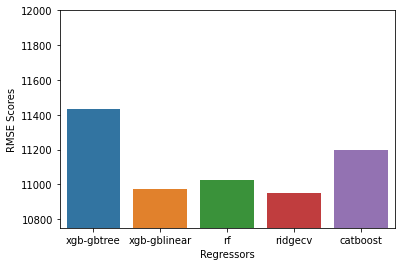

In [322]:
ax = sns.barplot(x = list(rmsescores.keys()),y = list(rmsescores.values()))
ax.set_ylim(10750,12000)
ax.set_xlabel('Regressors')
ax.set_ylabel('RMSE Scores')
plt.show()

## We would therefore prefer using RidgeCV for prediction.

# FINAL PREDICTION

# However, before we predict we cannot ascertain if the prediction is right or not

In [356]:
predlr = lr.predict(masterdf)
lrdata = {'Links':list(newsarts[:25]),'Predicted Virality':list(predlr)}
pd.DataFrame(lrdata).reindex(np.arange(0,25,1))

,Links,Predicted Virality
0,https://www.bbc.com/news/live/world-52450742,2.449992e+05
1,https://www.bbc.com/news/world-us-canada-52450692,3.910556e+05
2,https://www.bbc.com/news/world-asia-52450978,8.021755e+05
3,https://www.bbc.com/news/world-asia-india-5245...,3.183050e+05
4,https://www.bbc.com/news/world-latin-america-5...,5.168703e+05
5,https://www.bbc.com/news/world-us-canada-52451094,4.531630e+05
6,https://www.bbc.com/news/live/world-52450742,2.449992e+05
7,https://www.bbc.com/news/world-us-canada-52450692,3.910556e+05
8,https://www.bbc.com/news/world-asia-52450978,8.021755e+05
9,https://www.bbc.com/news/world-asia-india-5245...,3.183050e+05


In [357]:
predcb = cb.predict(masterdf)
cbdata = {'Links':list(newsarts[0:25]),'Predicted Virality':list(predcb)}
pd.DataFrame(cbdata).reindex(np.arange(0,25,1))

,Links,Predicted Virality
0,https://www.bbc.com/news/live/world-52450742,11013.092669
1,https://www.bbc.com/news/world-us-canada-52450692,17610.106121
2,https://www.bbc.com/news/world-asia-52450978,21797.972444
3,https://www.bbc.com/news/world-asia-india-5245...,15086.215630
4,https://www.bbc.com/news/world-latin-america-5...,19162.451402
5,https://www.bbc.com/news/world-us-canada-52451094,23300.845736
6,https://www.bbc.com/news/live/world-52450742,11013.092669
7,https://www.bbc.com/news/world-us-canada-52450692,17610.106121
8,https://www.bbc.com/news/world-asia-52450978,21797.972444
9,https://www.bbc.com/news/world-asia-india-5245...,15086.215630


In [358]:
predrf = rf.predict(masterdf)
rfdata = {'Links':list(newsarts[0:25]),'Predicted Virality':list(predrf)}
pd.DataFrame(rfdata).reindex(np.arange(0,25,1))

,Links,Predicted Virality
0,https://www.bbc.com/news/live/world-52450742,6148.402891
1,https://www.bbc.com/news/world-us-canada-52450692,3958.683180
2,https://www.bbc.com/news/world-asia-52450978,4821.097234
3,https://www.bbc.com/news/world-asia-india-5245...,5371.118586
4,https://www.bbc.com/news/world-latin-america-5...,3980.483000
5,https://www.bbc.com/news/world-us-canada-52451094,3593.789008
6,https://www.bbc.com/news/live/world-52450742,6148.402891
7,https://www.bbc.com/news/world-us-canada-52450692,3958.683180
8,https://www.bbc.com/news/world-asia-52450978,4821.097234
9,https://www.bbc.com/news/world-asia-india-5245...,5371.118586


In [359]:
predxgb = xgb2.predict(masterdf)
xgbdata = {'Links':list(newsarts[0:25]),'Predicted Virality':list(predxgb)}
pd.DataFrame(xgbdata).reindex(np.arange(0,25,1))

,Links,Predicted Virality
0,https://www.bbc.com/news/live/world-52450742,5286.192383
1,https://www.bbc.com/news/world-us-canada-52450692,6212.385254
2,https://www.bbc.com/news/world-asia-52450978,8425.513672
3,https://www.bbc.com/news/world-asia-india-5245...,5907.265625
4,https://www.bbc.com/news/world-latin-america-5...,6851.815918
5,https://www.bbc.com/news/world-us-canada-52451094,6481.937988
6,https://www.bbc.com/news/live/world-52450742,5286.192383
7,https://www.bbc.com/news/world-us-canada-52450692,6212.385254
8,https://www.bbc.com/news/world-asia-52450978,8425.513672
9,https://www.bbc.com/news/world-asia-india-5245...,5907.265625


# OBSERVATION

## On a whole, we observe that RidgeCV gives us predictions that are more than 10x the predictions by other models, on an average.

# FURTHER IMPROVEMENTS

## 1. Other features, with low importance, could be experimented with.
## 2. Used prediction models could be improvised with time